# **Progetto:** de-noiser automatico basato su campionamento e profilazione del rumore

### **Autore:** Francesco Spezia
### **Collaboratori:** Roberto Lazzarini

## **Obiettivo:** 
#### Creare un tool in grado di ridurre vari tipi di rumore da un file audio, basandosi sull'analisi di una porzione di rumore, effettuando una divisione in varie bande di frequenze e calcolando l'ampiezza media del volume di ogni banda, allo scopo di creare un profilo del rumore.
#### Il profilo ottenuto verrà poi utilizzato come filtro, da sommare al file audio completo, in modo da ridurre il rumore in punti specifici sull'intero spettro delle frequenze, senza intaccare troppo il segnale da ripulire.

##### Il programma è ispirato da strumenti avanzati di riduzione del rumore (come "Edison", riportato per esempio qui sotto), dove viene analizzato inizialmente il rumore per crearne un profilo, per poi applicarlo alla parte di segnale da ripulire, selezionando alcuni parametri di sensibilità dei filtri da eseguire.

<video controls src="src/Edison_example.mkv" type="video/mkv" width="500" height="340" />

# **Struttura del codice:**

<style>
    a {color: #013220}
    h3 {font-weight: bold;color: #013220}
    h4 {color: #013220}
</style>

<h3>1. <a href="#section_1"> Input </a></h3>
<h4>&emsp; 1.1<a href="#section_1_1"> Isolamento del rumore </a></h4>

<h3>2. <a href="#section_2"> Setup del rumore </a></h3>
<h4>&emsp; 2.1<a href="#section_2_1"> Creo l'oggetto "Band" </a></h4>
<h4>&emsp; 2.2<a href="#section_2_2"> Funzioni di utility </a></h4>

<h3>3. <a href="#section_3"> Profilazione </a></h3>

<h3>4. <a href="#section_4"> Applicazione del filtro </a></h3>
<h4>&emsp; 4.1 <a href="#section_4_1"> Funzione di filtraggio </a></h4>
<h4>&emsp; 4.2 <a href="#section_4_2"> Eseguo la funzione </a></h4>

<h3>5. <a href="#section_5"> Output </a></h3>

<h3>6. <a href="#section_6"> Considerazioni finali </a></h3>

<h4><a href="#section_7"><b>7. Bonus:</b> approcci utilizzati ed analisi dei fallimenti </a></h4>

### Librerie utilizzate

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy import signal
import IPython
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from pydub import AudioSegment
import pyaudio
import math
np.set_printoptions(suppress=True) # don't use scientific notation

### **Variabili Globali**

In [91]:
sr = 44100          # sampling rate
band_N = 150        # number of bands in noise profile

wavname = "Noise/01_rec_fesi.wav"   # load your noisy file here

start_point = 0     # ms, where to start isolating the noise in the file
cut_point = 5000    # ms, where to cut the isolated noise

### Funzione di utility: plotFile
input: asse x, asse y, etichetta del plot, nome asse x, nome asse y

In [92]:
def plotFile(x, y, label, xLabel, yLabel):
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x, y, '-r', label="%s" % label)
    plt.xlabel("%s" % xLabel)
    plt.ylabel("%s" % yLabel)
    plt.legend()
    plt.tight_layout()
    plt.grid()

<h3 id="section_1"><b>1. Input:</b> campionamento della registrazione originale</h3>

In [93]:
f_s, recording = wav.read(wavname)  # load as sample rate and signal
N = len(recording)                  # recording's length
t = 1/f_s * np.arange(N)            # recording's duration

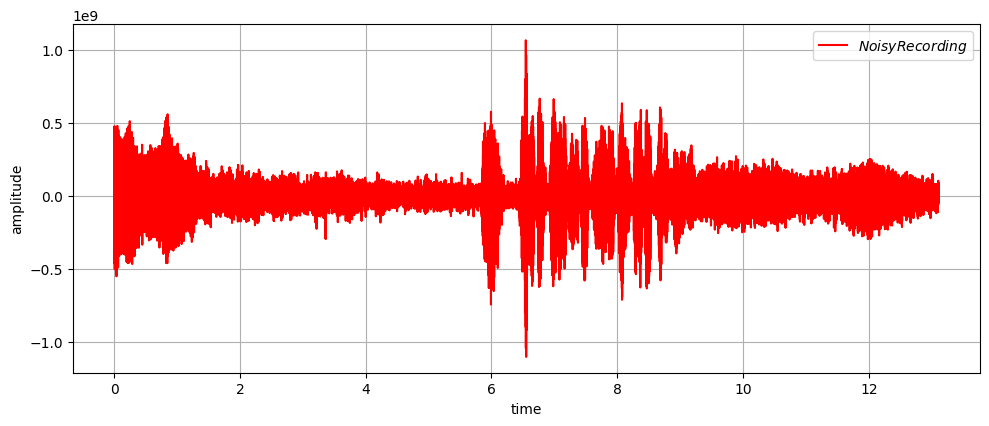

In [94]:
plotFile(t, recording, "$Noisy Recording$", "time", "amplitude")
plt.show()

IPython.display.Audio(recording, rate=sr)

<h4 id="section_1_1"><b>1.1 Input:</b> isolo la parte del file audio originale con solo rumore</h4>

In [95]:
wavname_noise_sample = "noise_sample.wav"       # create noise file

cut = AudioSegment.from_file(wavname, "wav")
cut = cut[start_point:cut_point]
cut.export(wavname_noise_sample, format="wav")  # export the isolated noise

# load the isolated noise as sample rate and signal
f_s_noise, noise_sample = wav.read(wavname_noise_sample)

##### Elaborazione del rumore isolato

In [96]:
N_noise = len(noise_sample)                     # isolated noise length
t_noise = 1/f_s_noise * np.arange(N_noise)      # isolated noise duration
f = f_s_noise/N_noise * np.arange(N_noise)      # isolated noise frequency

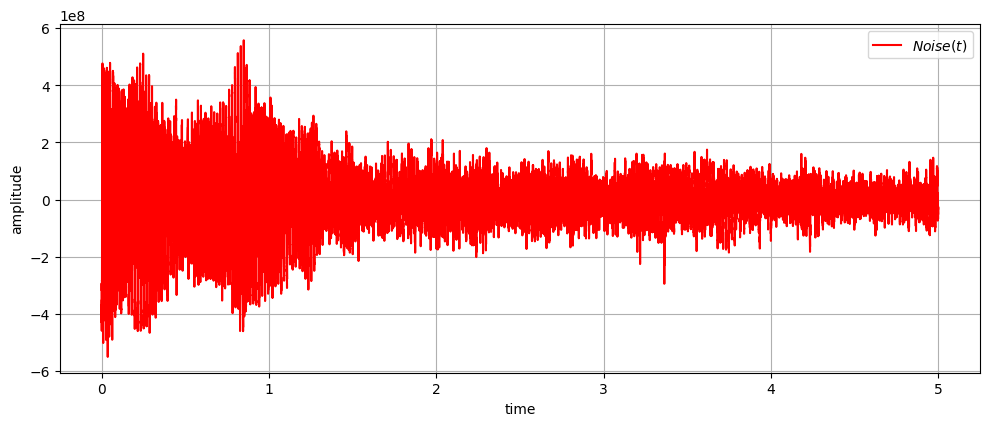

In [97]:
plotFile(t_noise, noise_sample, "$Noise(t)$", "time", "amplitude")
# plt.xlim(0,0.1)     # uncomment to zoom on the noise waveshape
plt.show

IPython.display.Audio(noise_sample, rate=sr)

<h3 id="section_2"><b>2. Setup del rumore:</b> trasformo in fourier il rumore isolato
</h3>

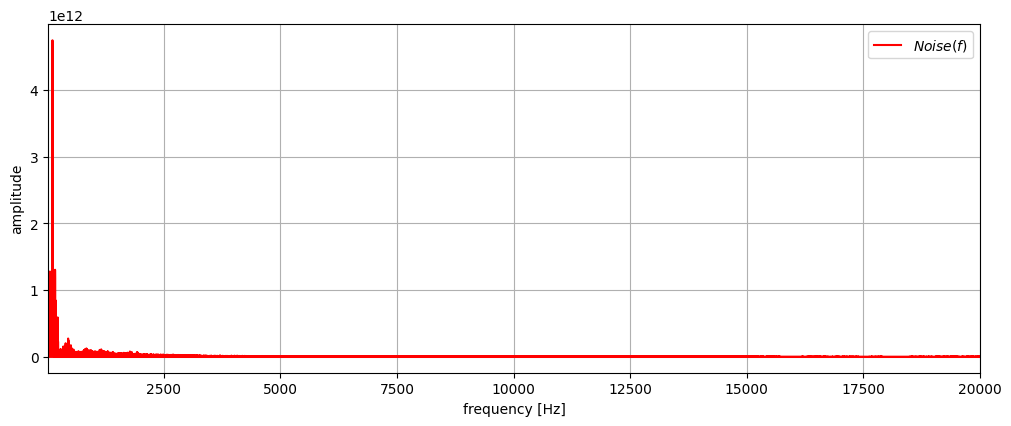

In [98]:
Fourier_noise = np.fft.fft(noise_sample)
freq_noise = np.fft.fftfreq(N_noise, 1/f_s_noise)

N_2_noise = math.ceil(N_noise/2)    # divide noise length to use in further operations

plotFile(freq_noise, np.abs(Fourier_noise), "$Noise(f)$", "frequency [Hz]", "amplitude")
plt.xlim([20,20000])                # plot only frequencies between 20Hz and 20kHz (we will operate only on the audible spectrum) 
plt.show()

<h4 id="section_2_1"><b>2.1 Setup del rumore:</b> creo l'oggetto "Band" </h4>
&emsp;&emsp; L'oggetto sarà utilizzato per contenere le informazioni di ogni banda in cui verrà suddiviso il sample del rumore

In [99]:
class Band (object):
    def __init__(self, low_treshold, high_treshold, avg_amp):
        self.low_treshold = low_treshold
        self.high_treshold = high_treshold
        self.avg_amp = avg_amp
    
    def printBand(self):
        return("Band: [%dHz - %dHz]\t Volume: %d\n" % (self.low_treshold, self.high_treshold, self.avg_amp))

<h4 id="section_2_2"><b>2.2 Setup del rumore:</b> funzioni di utility </h4>

In [100]:
# return the list position of a given frequency
def bandCut (N_frames, freqList, frequency):
    for i in range (N_frames):
        if math.floor(freqList[i]) == frequency:
            return i
    
    print("bandCut error")
    return False

In [101]:
# print every band of the noise profile
def printBands (noiseProfile):
    profile_out = open("Output/printBands.txt", "w")
    
    for Band in noiseProfile:
        profile_out.write(Band.printBand())
    
    profile_out.close()

In [102]:
# plot the full noise profile
def plotProfile (noiseProfile):
    x = []
    y = []

    for i in range (len(noiseProfile)-1):
        x.append(noiseProfile[i].high_treshold)
        y.append(noiseProfile[i].avg_amp)

    x[0] = noiseProfile[0].low_treshold

    plotFile(x, y, "$Noise Profile$", "frequency [Hz]", "amplitude")
    plt.xlim([20,22000])
    plt.show()

In [103]:
# filter all the frequencies beside the audible spectrum [20Hz, 20kHz]
def simpleFilter (unfiltered, frequencies):
    low_index = np.argwhere(np.abs(frequencies) <= 20)
    high_index = np.argwhere(np.abs(frequencies) >= 20000)

    unfiltered[low_index] = 0
    unfiltered[high_index] = 0

    return unfiltered

<h3 id="section_3"><b>3. Profilazione:</b> creo il profilo del rumore</h3>

In [104]:
Fourier_noise = simpleFilter(Fourier_noise, freq_noise) # initial 20-20k filtering

noise_profile = []          # our noise profile will be a list of Band objects

band_size = math.floor(N_2_noise/band_N)            # Band width


low_cut = bandCut(N_2_noise, freq_noise, 20)        # get starting and end position
high_cut = bandCut(N_2_noise, freq_noise, 20000)    # at 20 and 20k Hz

i = low_cut                                         # i will be our iterator

In [105]:
# populate the bands list

while i < high_cut-1:    
    band_min = freq_noise[i]    # band minimum frequency
    
    j = i+band_size             # band width offset

    # offset for the last band
    if (j >= high_cut-1):
        j = high_cut-2
    
    band_max = freq_noise[j]    # band maximum frequency
    band_avg = Fourier_noise[i] # band average amplitude

    divider = 1
    for k  in range(i+1,j):
        if (Fourier_noise[k]>0):
            band_avg += Fourier_noise[k]
            divider += 1

    # calculate band average amplitude
    # band_avg = band_avg/divider

    if band_avg < 0:
        band_avg = 0
    
    # append band with collected parameters to noise profile
    noise_profile.append(Band(band_min, band_max, band_avg))

    # increment iterator
    i = j+1                    # go to next frequency in list

Stampa del contenuto di ogni banda del profilo del rumore ottenuto presente in _'Output/printBands.txt'_

Noise profile length: 136 bands


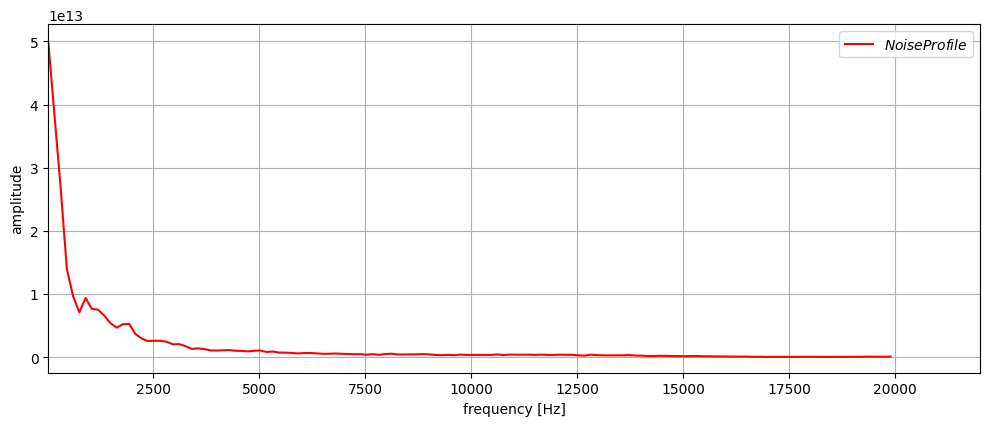

In [106]:
print("Noise profile length: %s bands" % len(noise_profile))

printBands(noise_profile)

plotProfile(noise_profile)


<h3 id="section_4"><b>4. Applicazione del filtro:</b> analizzo il file completo in fourier</h3>

In [107]:
# make FastFourierTransorm of the noise sample, and get its frequencies
Fourier_rec = np.fft.fft(recording)
freq_rec = np.fft.fftfreq(N, 1/f_s)

N_2_rec = math.ceil(N/2)    # half of rec's length

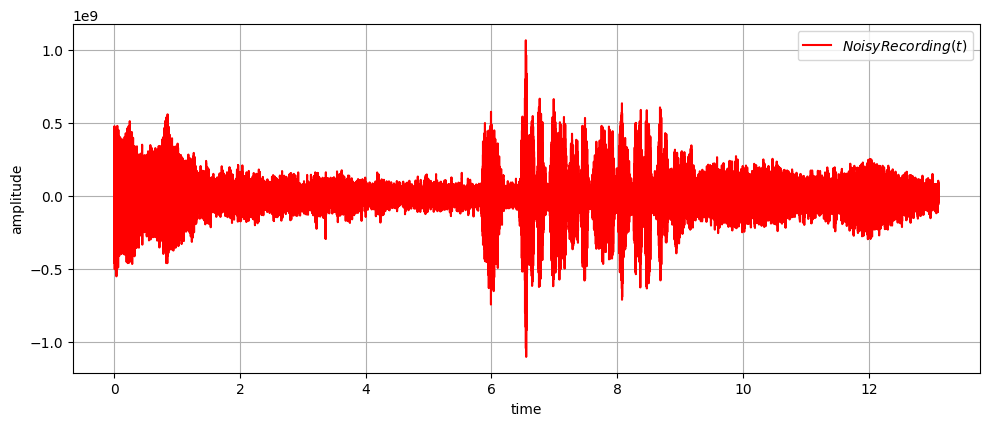

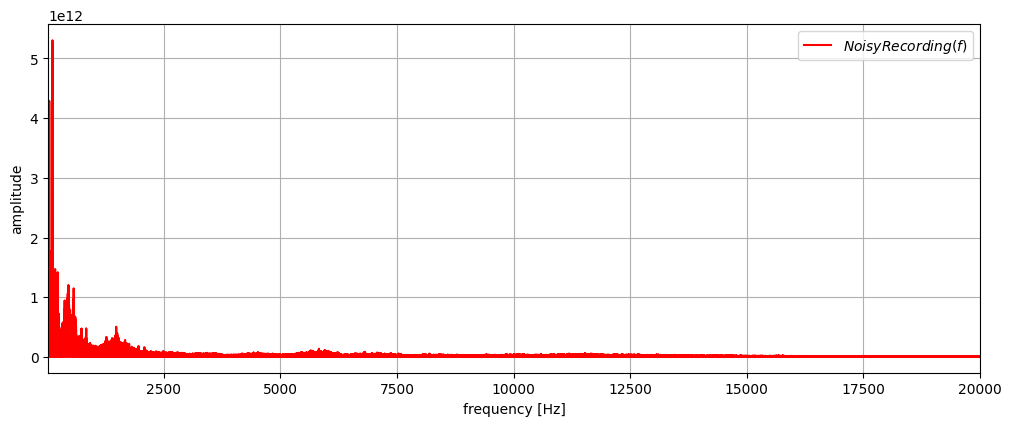

In [108]:
plotFile(t, recording, "$Noisy Recording(t)$", "time", "amplitude")
plt.show()
plotFile(freq_rec, np.abs(Fourier_rec), "$Noisy Recording(f)$", "frequency [Hz]", "amplitude")
plt.xlim([20,20000])
plt.show()

<h4 id="section_4_1"><b>4.1 Applicazione del filtro:</b> funzione di filtraggio in FFT banda per banda</h4>

In [109]:
def filterBands (filter, unfiltered, frequencies):
    manipulated = 0     # counter of number of frequency points affected by filter

    for band in filter:
        # list of indexes of band in frequencies
        index = np.argwhere((np.abs(frequencies)>=band.low_treshold)*(np.abs(frequencies)<band.high_treshold))
        index = np.squeeze(index)

        for i in index:
            if (band.avg_amp>0) & (unfiltered[i]>0):
                check = unfiltered[i]
                unfiltered[i] -= (band.avg_amp)

                if (check!=unfiltered[i]): manipulated += 1

    print("Number of frequencies filtered: ", manipulated)
    return unfiltered

<h4 id="section_4_2"><b>4.2 Applicazione del filtro:</b> eseguo la funzione filterBands sulla registrazione completa</h4>

Number of frequencies filtered:  257184


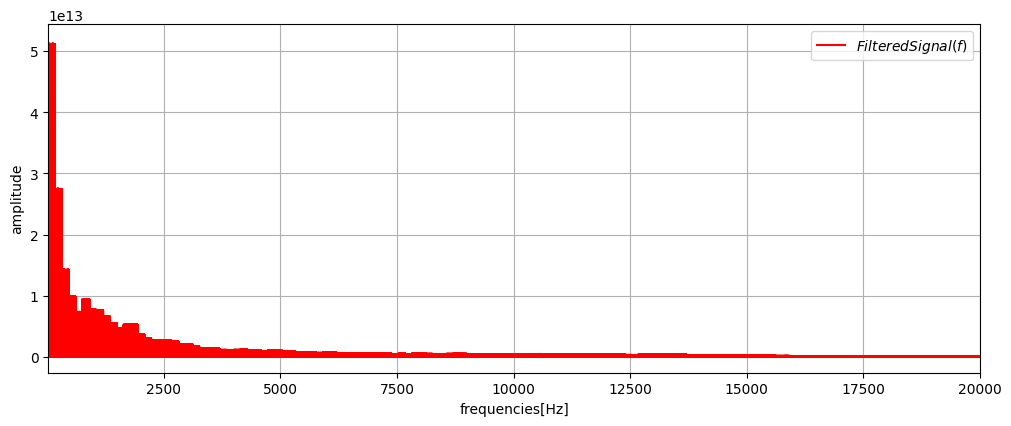

In [110]:
filtered_by_bands = filterBands(noise_profile, Fourier_rec, freq_rec)
filtered = simpleFilter(filtered_by_bands, freq_rec)    # filter out frequencies <20Hz and >20kHz

# length check
if len(Fourier_rec)!=len(filtered): print("Filtering error")

plotFile(freq_rec, np.abs(filtered), "$Filtered Signal(f)$", "frequencies[Hz]", "amplitude")
plt.xlim([20,2e4])
plt.show()

<h3 id="section_5"><b>5. Output:</b> trasformata inversa del file filtrato</h3>

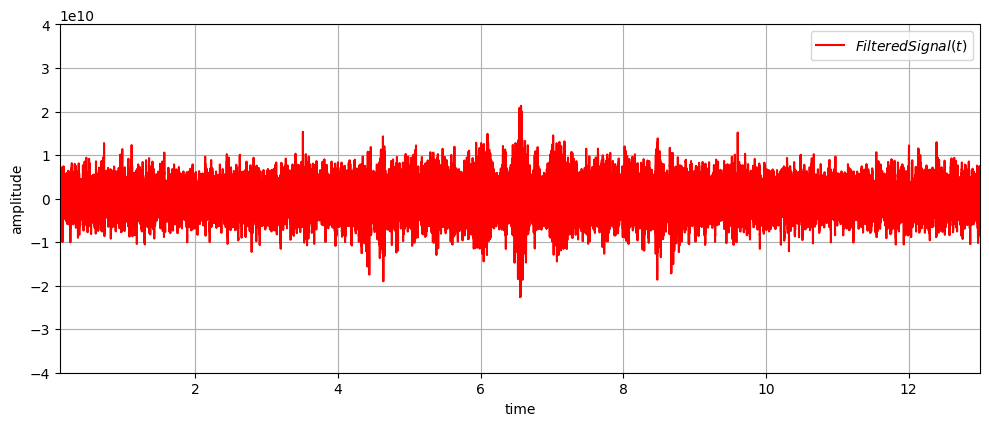

In [114]:
filtered_recording = np.fft.ifft(filtered)
plotFile(t, filtered_recording, "$Filtered Signal(t)$", "time", "amplitude")
plt.xlim([0.1,13])
plt.ylim([-4e10,4e10])
plt.show()

IPython.display.Audio(filtered_recording, rate=sr)

<h3 id="section_5"><b>6. Considerazioni finali:</b></h3>

Come i vari de-noiser in circolazione, il programma funziona principalmente per rumori relativamente **statici** e **costanti**, in quanto opera su un'analisi in fourier, che rappresenta il segnale all'infuori della dimensione temporale, con però risultati spesso meno effecienti (come preventivato d'altronde).

Infatti una semplice divisione _lineare_ in bande con relativa media delle ampiezze non tiene conto di vari aspetti della percezione ed elaborazione del suono, che tendono quindi a creare artefatti e distorsioni sul segnale finale.
Ad esempio, la _quantità di informazione_ presente nel suono non è affatto lineare, nè sullo spettro delle **frequenze** nè sulla scala dell'**ampiezza**: una rappresentazione (e quindi anche una suddivisione in bande per la profilazione di un segnale) più fedele all'effettiva quantità e qualità di informazione relativa allo spettro delle frequenze andrebbe effettuata in scala **semilogaritmica**. Per esempio una banda larga **[200 - 500]Hz** dovrebbe essere circa equivalente ad una banda **[2000 - 5000]Hz** e ad una banda **[8500 - 20000]Hz** come quantità di informazione contenuta in essa.
Anche relativamente alla misura dell'ampiezza d'onda un approccio lineare porta a gravi imprecisioni per motivazioni fisiche, digitali e di percezione umana.
Per ovviare a questi errori vi è la misurazione in _Decibel_ (dB), anch'essa in scala **logaritmica**, che vede l'ampiezza d'onda come un rapporto tra l'onda misurata e un'unità di riferimento (solitamente la **soglia dell'udibile umano** -> **0dB**). In questo modo è possibile effettuare **operazioni** sui segnali in modo più **preciso** e **verosimile** alla realtà (ad es. 30dB + 40dB == 70dB, cosa non necessariamente vera operando con unità di misura fisiche).


Purtroppo per limitazioni di tempo e di competenze non mi è stato possibile implementare il programma tenendo conto di questi accorgimenti, il che ha portato ad interessanti risultati nei vari output finali: a seconda del file di input utilizzato ho spesso ottenuto diversi generi di distorsioni e manipolazioni del segnale "filtrato".

Ad esempio nel caso del file numero **05**, dove il rumore di fondo ha subito una filtrazione quasi perfetta sulle basse frequenze, creando però molti artefatti sulle frequenze medio-alte, e senza intaccare la traccia di batteria.

Un altro caso interessante è quello del file numero **02**, nel quale il numero di bande scelte cambia drasticamente il risultato ottenuto, in quanto più bande si utilizzano per profilare il rumore, più il segnale di pianoforte rimane intaccato, a scapito però di un peggiore filtraggio del rumore.

O ancora in altri file di prova si sono verificati artefatti di distorsione temporale, dove il segnale pulito è stato sovrapposto al segnale stesso, ma riprodotto al contrario.
Mentre invece in file specifici dove il rumore si trova relativamente isolato dal segnale, formato da pochi picchi distinti e posizionato nelle frequenze medio-basse, si riesce ad ottenere un filtraggio quasi perfetto. 

<h3 id="section_7"><b>7. Bonus:</b> approcci utilizzati ed analisi dei fallimenti</h3>

Durante lo sviluppo di questo progetto ho provato vari metodi per ovviare alle problematiche insite agli obiettivi da raggiungere, che hanno portato a questa versione finale.
<br><br>
Inizialmente il rumore veniva _"discretizzato"_ maggiormente suddividendo i valori della trasformata di Fourier, campionandone i valori ogni 2Hz, allo scopo di avere direttamente solo i valori interni allo spettro udibile, di facilitarne la suddivisione in bande, ed eventualmente di effettuare una rudimentale conversione in Decibel, moltiplicando i valori di ampiezza per 10(log<sub>10</sub>), effettuando questo "campionamento" anche nella trasformata del file completo.

Tuttavia questa operazione, nonostante sarebbe stata appropriata nell'ambito di una sommaria analisi del rumore, andava a distorcere troppo il segnale, perdendo moltissime informazioni anche nella dimensione temporale, sia con questo sottocampionamento, sia con la pseudo-conversione dell'ampiezza in dB.
<br><br><br>

Un'altra sezione particolarmente critica è la funzione di filtraggio banda per banda _filterBands_. Avendo abbandonato l'approccio citato sopra di suddivisione in liste approssimate del segnale, ho riscontrato alcune difficoltà di grammatica delle liste di python, riguardo alla selezione delle frequenze su cui effettuare le operazioni di filtraggio, ma dopo varie iterazioni e modifiche al codice di base sono riuscito ad implementare una funzione con un approccio il più simile possibile alle funzioni di filtraggio viste a lezione.
<br><br><br>

Infine, la sezione di codice più problematica, nonché cardine del progetto, è senza dubbio stata la profilazione del rumore stessa.

Dopo aver dovuto lasciar perdere la conversione in Decibel e la suddivisione delle frequenze in scala semlilogaritmica (perché ben troppo complesse nell'ambito del progetto) la costruzione di un algoritmo funzionante che suddividesse in bande adiacenti tutte le frequenze rilevate dalla trasformazione in Fourier non è stato semplice, ma sono comunque riuscito ad arrivare ad un risultato soddisfacente, al costo di perdere un numero irrisorio di bande al di là dello spettro udibile.

Il problema maggiore l'ho riscontrato nell'operazione di calcolo dell'ampiezza media di ogni banda, molto probabilmente a causa della non linearità della potenza di un segnale sonoro. Infatti calcolando un'esatta media matematica per ogni banda del profilo, si ottengono valori di ampiezza del segnale di svariati ordini di grandezza inferiori del dovuto, che comportano una variazione essenzialmente nulla del segnale completo in un'operazione di somma.

Il compromesso che ho trovato dare risultati migliori causando meno distorsioni è stato quello di ignorare del tutto ogni valore $\mathbf{\le}$ 0 del rumore, sommando semplicemente tutti i valori positivi senza dividere successivamente per il numero di valori sommati. In questo modo si va ad effettuare una sommatoria dei valori di ampiezza, piuttosto che la media aritmetica, per ottenere un filtro più potente con un impatto significativo sul segnale finale. Un'altra possibile soluzione temporanea sarebbe di moltiplicare per un coefficiente i valori ottenuti da ogni banda, ma senza una effettiva conversione dei valori delle ampiezze e operando linearmente sullo spettro delle frequenze, si otterrebbero comunque risultati distorti ed imprecisi.